Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt
import matplotlib 

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
# RUN ON DEVICE: device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def decorrelate(num_epochs, data, model, eta):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        model.weight -= eta * model.weight.grad
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

In [4]:
def plot_results(model, L, A1, A2):

    plt.figure(figsize=(14,9))

    plt.subplot(2,2,1)
    plt.plot(L)
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.subplot(2,3,3)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['correlated', 'decorrelated'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.legend();

    plt.subplot(2,3,4)
    min = np.max([np.min(np.abs(model.weight.numpy().flatten())), 1e-10])
    max = np.max(np.abs(model.weight.numpy().flatten()))
    plt.imshow(np.abs(model.weight), cmap=plt.get_cmap('hot'), interpolation='nearest', norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
    plt.title('|decorrelation weights|')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(2,3,5)
    min = np.min(np.stack([A1.numpy().flatten(), A2.numpy().flatten()]))
    max = np.max(np.stack([A1.numpy().flatten(), A2.numpy().flatten()]))
    plt.imshow(A1, cmap=plt.get_cmap('hot'), interpolation='nearest') #, norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
    plt.title('$x_i x_j$')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(2,3,6)
    plt.imshow(A2, cmap=plt.get_cmap('hot'), interpolation='nearest') #, norm=matplotlib.colors.LogNorm(vmin=min, vmax=max))
    plt.title('$x_i x_j$ decorrelated')
    plt.colorbar(fraction=0.046, pad=0.04);

We start by showing effective decorrelation of correlated input

In [5]:
num_samples=1000
num_features=100
num_epochs=3000
seed=42
eta=1e-2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a decorrelator
model = Decorrelation(in_features=num_features, variance = None) # variance can be None (no variance contraint) or 'input or 1.0 or (d1,...,dn)

L, A1, A2 = decorrelate(num_epochs, data, model, eta)


iteration 0	loss: 0.044
iteration 1	loss: 0.016
iteration 2	loss: 0.009
iteration 3	loss: 0.006
iteration 4	loss: 0.004
iteration 5	loss: 0.003
iteration 6	loss: 0.003
iteration 7	loss: 0.002
iteration 8	loss: 0.002
iteration 9	loss: 0.002
iteration 10	loss: 0.002
iteration 11	loss: 0.002
iteration 12	loss: 0.002
iteration 13	loss: 0.002
iteration 14	loss: 0.002
iteration 15	loss: 0.002
iteration 16	loss: 0.002
iteration 17	loss: 0.002
iteration 18	loss: 0.002
iteration 19	loss: 0.002
iteration 20	loss: 0.002
iteration 21	loss: 0.002
iteration 22	loss: 0.002
iteration 23	loss: 0.002
iteration 24	loss: 0.002
iteration 25	loss: 0.002
iteration 26	loss: 0.002
iteration 27	loss: 0.002
iteration 28	loss: 0.002
iteration 29	loss: 0.002
iteration 30	loss: 0.002
iteration 31	loss: 0.002
iteration 32	loss: 0.002
iteration 33	loss: 0.002
iteration 34	loss: 0.002
iteration 35	loss: 0.002
iteration 36	loss: 0.002
iteration 37	loss: 0.002
iteration 38	loss: 0.002
iteration 39	loss: 0.002
iteration 

In [6]:
# torch.mean(data**2, axis=0)

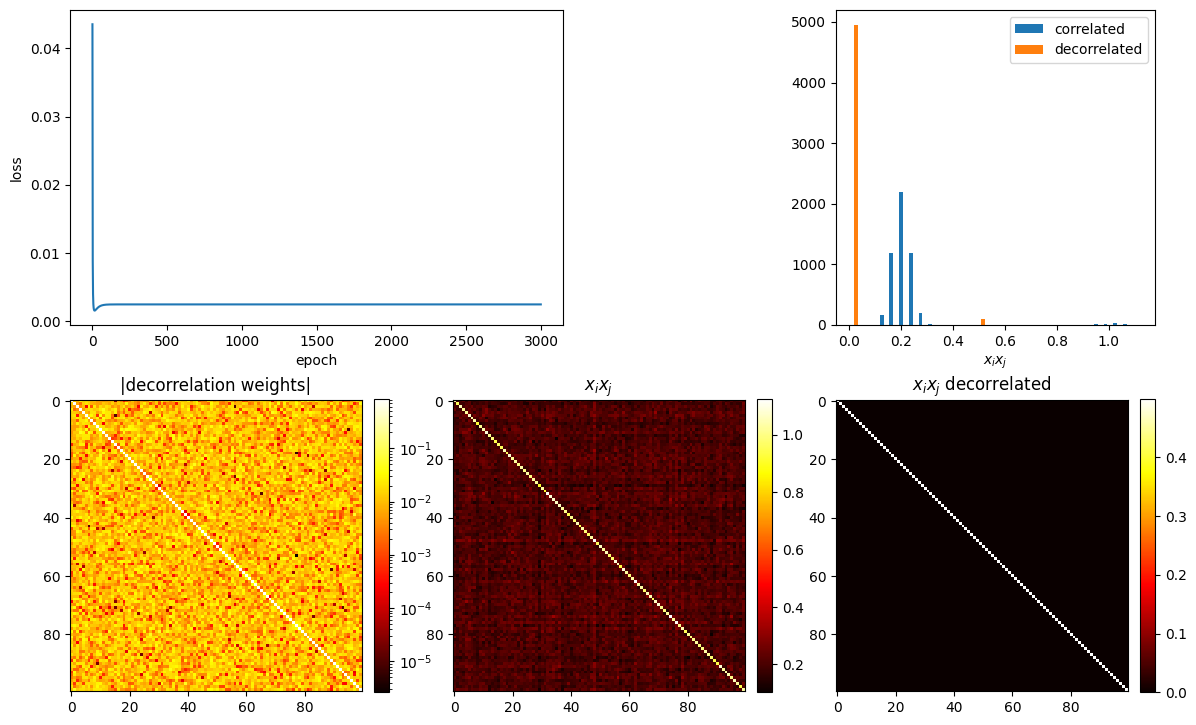

In [7]:
plot_results(model, L, A1, A2)

In [8]:
torch.diag(A2)

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])

Decorrelation of correlated input using DecorConv2d

In [9]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=1000
seed=42
eta=1e-3
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, variance=1.0, downsample_perc=downsample_perc)

L, A1, A2 = decorrelate(num_epochs, data, model, eta) 


AttributeError: 'DecorConv2d' object has no attribute 'uncorrelated'

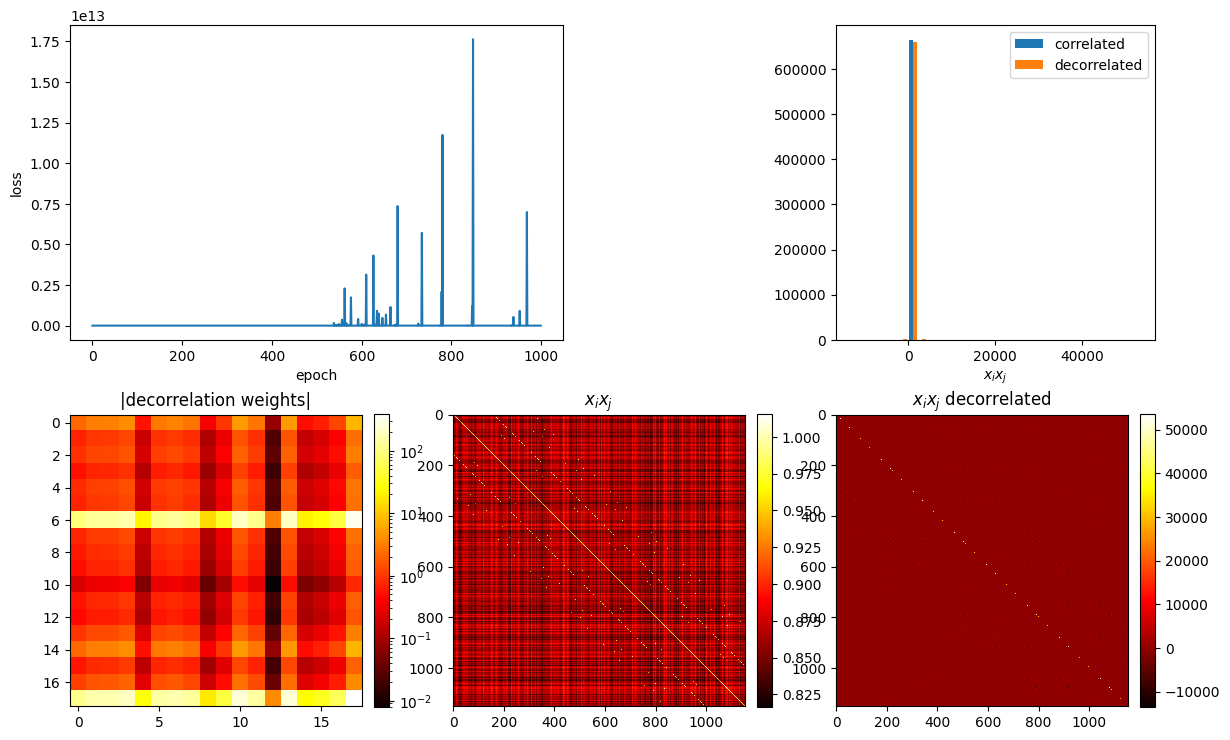

In [ ]:
plot_results(model, L, A1, A2)

In [ ]:
torch.diag(A2)

tensor([2.0782e+01, 2.0660e+00, 3.2184e+00,  ..., 1.1924e+00, 4.4737e+00,
        4.6483e+04])